# Homework 1

## Physics 7810
## Due January 27, 2020

## H1.1 - Ordinary differential equation (ODE) solvers

In the first tutorial, you solved the equations of motion for the 1D simple harmonic oscillator (SHO) using various simple integration algorithms (Euler, symplectic Euler, and velocity Verlet). This is an example of an *initial value problem*. A number of sophisticated, general-purpose ODE solvers exist to solve such problems, based on algorithms such as the Runge-Kutta and predictor-corrector methods, with enhancements such as variable step size and Richardson extrapolation to control and maintain accuracy.

While symplectic integrators such as velocity Verlet are well-suited for Hamiltonian systems (where the energy is conserved), these more general ODE solvers are typically the methods of choice for solving systems of differential equations where there is no conserved energy or Hamiltonian.

Revisit the 1D SHO, and solve the equations of motion using one of these general purpose methods (the widely used implicit Runge-Kutta method of order 5(4) (RK45) might be a good choice). A number of ODE solvers (including RK45) are available in the `scipy.integrate` library, which can be imported using `import scipy.integrate as integrate`.

As a reminder, Hamilton's equations of motion for the 1D SHO are:

$$\dot{X} = \frac{\partial \cal{H}}{\partial P} = P$$

$$\dot{P} = - \frac{\partial \cal{H}}{\partial X} = - X,$$

Write a python program to integrate these equations of motion using RK45 (`scipy.integrate.RK45`) and compare the results with those obtained using the velocity Verlet algorithm on both short timescales (a few periods of oscillation) and very long timescales (thousands of periods of oscillation), e.g., by making phase space plots and energy plots. Is the RK45 algorithm stable, or does the energy drift over long timescales? Compare the relative short-time accuracies of RK45 and velocity Verlet by measuring the amplitude (standard deviation) of energy fluctuations about the exact value ($E = 1$).

### Solution
To improve the flexibility of the code, in the folder `CompPhysLib`, I wrote a Python library `SHO_integrators.py` for solving problems in Tutorial_01 and Homework_01 here, which can be imported as below.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, '../')
from CompPhysLib.SHO_integrators import SHO_integrators
from scipy.integrate import solve_ivp
from numpy.linalg import norm

#### Part 1 of H1.1: Comparison of RK45 scheme with Verlet algorithm on a short timescale ($20 \pi$)

The standard deviations of Verlet and RK45 algorithm are 0.015270101860639701 and 0.0005413788307580262, respectively.


<Figure size 432x288 with 0 Axes>

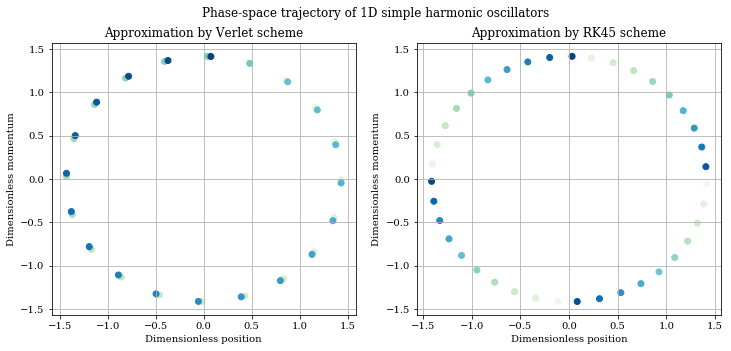

<Figure size 432x288 with 0 Axes>

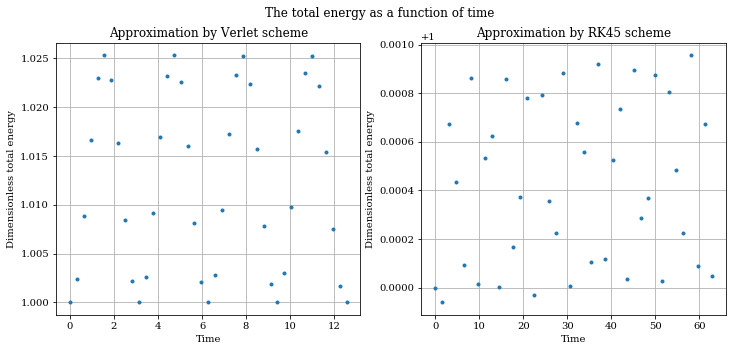

In [2]:
def SHO(t, z):
    x, p = z          # z: vector of the state variable
    return [p, -x]    # dx/dt = p, dp/dx = -x

def RK45_Verlet(t_final):
    n = int(t_final / (0.5 * np.pi))   # number of data pionts
    t = np.linspace(0, t_final, n)     # range of time to integrate
    x_0, p_0 = 0, np.sqrt(2)

    # solve_ivp(func, t_span, y0, ...)
    sol = solve_ivp(SHO, [0, t_final], [x_0, p_0], dense_output=True)
    z = sol.sol(t)   # x(t) = z[0], p(t) = z[1]
    x_rk45, p_rk45 = z[0], z[1]

    # RK45
    SI = SHO_integrators()
    RK45 = SI.integrators(integrator='RK45', dt=t[-1] - t[-2], n=len(t))
    RK45.x_approx, RK45.p_approx = z[0], z[1]
    RK45.E = 0.5 * np.power(RK45.x_approx, 2) + 0.5 * np.power(RK45.p_approx, 2)
    RK45.RMSD = np.sqrt((1/len(RK45.E) * np.sum(np.power(RK45.E - 1, 2))))

    # Verlet
    SI = SHO_integrators()
    verlet = SI.integrators(integrator='Verlet', n=n, dt=0.1*np.pi)

    SI.SHO_plots_compare(verlet, RK45, False)
    
    print('The standard deviations of Verlet and RK45 algorithm are %s and %s, respectively.' %(verlet.RMSD, RK45.RMSD))

RK45_Verlet(20 * np.pi)

As shown above, in terms of the phase-space trajectory, both algorithms provide a good estimation. On the other hand, RK45 scheme obviously has a smaller uncertainty compared to Verlet scheme, with a standard deviation in the total energy as $0.00054$, which is much smaller than the one of Verlet scheme ($0.1527$). Therefore, for a short timescale, RK45 scheme is more robust than Verlet scheme.

#### Part 2 of H1.1: Comparison of RK45 scheme with Verlet algorithm on a long timescale ($5000 \pi$)

The standard deviations of Verlet and RK45 algorithm are 0.01549004402816966 and 0.018863746338892044, respectively.


<Figure size 432x288 with 0 Axes>

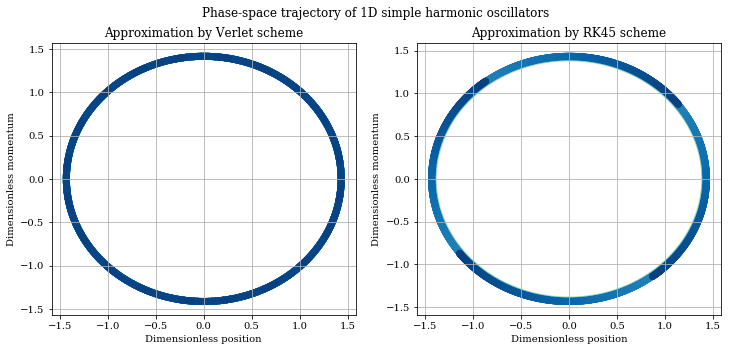

<Figure size 432x288 with 0 Axes>

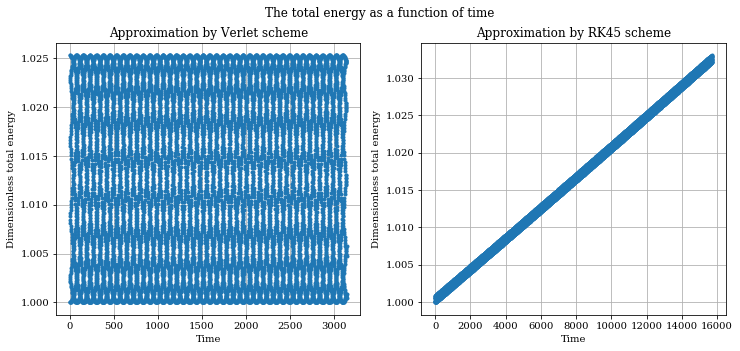

In [3]:
RK45_Verlet(5000 * np.pi)

Unlike the situation given a short timescale, with a long timescale like $5000\pi$, RK45 scheme shows a larger standard deviation than Verlet scheme. As shown in the figure above, the energy estimated by RK45 drift over long timescales (accordingly, the standard deviation in the estimation of the total energy increases with time), which indicates that for a long simulation, Verlet scheme is apparently a better choice than RK45 scheme.

## H1.2 - Motion in a central force potential

Write a python program to simulate the motion of a particle in a central force potential in two dimensions. Take the form of the potential to be

$$
U({\bf r}) = u r^n,
$$

where ${\bf r} = (x,y)$ is the 2D position of the particle, $r = |{\bf r}|$, and $n$ is a positive integer.

First write down the Hamiltonian for this system, and derive Hamilton's equations of motion. Then use the velocity Verlet algorithm to numerically integrate the equations of motion for a few specific cases, say $n = 2$ (2D simple harmonic oscillator) and $n = 4$. Adjust the timestep to ensure good energy conservation, and plot the trajectory of the particle in the $x-y$ plane for various initial conditions. Verify that the particle has the expected elliptical orbit for $n = 2$, and explore how the nature of the orbit changes with varying $n$.

A basic result from classical mechanics is the *virial theorem*, which relates the average kinetic energy $\langle K \rangle$ and the average potential energy $\langle U \rangle$ for a single particle in a central force potential,

$$
\langle K \rangle = \frac{n}{2} \langle U \rangle,
$$

where the angle brackets denote an average over an integral number of periods of the motion, or over a sufficiently long timescale that the averages converge to well-defined values (many periods of motion).

Verify the virial theorem for a few specific values of $n$, by calculating $\langle K \rangle$ and $\langle U \rangle$ from long simulation trajectories.

Repeat these steps for a central force potential of the form

$$
U({\bf r}) = - u r^{-n},
$$

where $n$ is a positive integer. Of particular interest is the case $n = 1$ (gravitational or Coulomb potential).

### Solution

#### Part 1 of H1.2: Hamiltonian's equations of motion
The Hamiltonian for this system is $H(p,r)=\frac{p^{2}}{2m} + ur^{n}$. Accordingly, the Hamiltonian's equations of motion should be
\begin{equation}
\dot{r} = \frac{\partial H}{\partial p} = \frac{p}{m}, \; \dot{p} = - \frac{\partial H}{\partial r} = unr^{n-1}
\end{equation}
For the sake of convenience, here we formulate this problem in dimensionless variables like we did in the class. Specifically, the units of length and momention are $r_{0} = (\frac{E}{u})^{\frac{1}{n}}$ and $p_0=\sqrt{Em}$, respectively. Defining the dimensionless position $R$ and the dimensionless momentum $P$ as below:
\begin{equation}
R = \frac{r}{r_{0}} = r/(\frac{E}{u})^{\frac{1}{n}} \Rightarrow r = R(\frac{E}{u})^{\frac{1}{n}}, \; p = \frac{P}{p_{0}} = p/\sqrt{Em} \Rightarrow P = p\sqrt{Em}
\end{equation}
we can write the Hamiltonian H(p,r) as:
\begin{equation}
E = H(p,r)=\frac{p^{2}}{2m} + ur^{n} = \frac{1}{2}EP^{2} + ER^{2} \Rightarrow {\cal H}(P,R) = H(P,R)/E = \frac{1}{2}P^{2} + R^{n} = 1
\end{equation}
where $E$ is the total energy of the system ($E=H(p,r)$) and ${\cal H}(P,R)$ is the dimensionless Hamiltonian (${\cal H}(P,X) = H(P,X) / E = 1$).
Finally, in terms of dimensionless unit, the Hamiltonian's equation of motion become:
\begin{equation}
\dot{P} = -\frac{\partial {\cal H}}{\partial R} = -n R^{n-1}, \; \dot{R} = \frac{\partial {\cal H}}{\partial P} = P
\end{equation}
Given that $U=ur^{n} \Rightarrow U(x,y) = u (x^{2} + y^{2})^{n/2}$, we can also express these equations in Cartesian coordinates:
$$\dot{x} = \frac{p_{x}}{m}, \; \dot{y} = \frac{p_{y}}{m}$$
where
$$\dot{p_{x}} = -\frac{\partial U(x,y)}{\partial x} = -unx(x^{2} + y^{2})^{\frac{1}{2}n - 1}, \; \dot{p_{y}} = -\frac{\partial U(x,y)}{\partial y} = -uny(x^{2} + y^{2})^{\frac{1}{2}n - 1}$$

#### Part 2 of H1.2: Numerical integration by velocity Verlet algorithm

Given the Hamiltonian's equation of motion above, the velocity Verlet algorithm can be expressed as 
$$ v_x \left(t + \frac{\Delta t}{2} \right) = v_x(t) +  \frac{\Delta t}{2 m} f_x(t) \Rightarrow p_x \left(t + \frac{\Delta t}{2} \right) = p_x \left(t \right) + \frac{1}{2} \Delta t \left( \frac{d p_{x}(t)}{dt} \right) \Rightarrow p_{x} \left( t + \frac{\Delta t}{2} \right) = p_{x}(t) - \frac{1}{2} nux(x^{2} + y^{2})^{\frac{n}{2}-1} \Delta t$$
$$ x(t + \Delta t) = x(t) + \frac{1}{m} p_x \left(t + \frac{\Delta t}{2} \right) \Delta t $$
$$ p_x(t + \Delta t) = p_x \left(t + \frac{\Delta t}{2} \right) - \frac{1}{2} nux(t + \Delta t)(x^{2}(t + \Delta t) + y^{2}(t + \Delta t))^{\frac{n}{2}-1} \Delta t$$

By symmetry, for the y-direction, we have:
$$ p_{y} \left( t + \frac{\Delta t}{2} \right) = p_{y}(t) - \frac{1}{2} nuy(x^{2} + y^{2})^{\frac{n}{2}-1} \Delta t$$
$$y(t + \Delta t) = y(t) + \frac{1}{m} p_y \left(t + \frac{\Delta t}{2} \right) \Delta t $$
$$ p_y(t + \Delta t) = p_y \left(t + \frac{\Delta t}{2} \right) - \frac{1}{2} nuy(t + \Delta t)(x^{2}(t + \Delta t) + y^{2}(t + \Delta t))^{\frac{n}{2}-1}\Delta t$$

Or in dimensionless variables, we have:
$$\dot{X_{i}} = \frac{\partial {\cal H}}{\partial P_{i}} = P_{i}, \; \dot{P_{i}}=-\frac{\partial {\cal} H}{\partial X_{i}} = \frac{\partial}{\partial X_{i}}((X_{i}X_{i})^{n/2})=-nX_{i}R^{n-2}, \; R=(X_{i}X_{i})^{2}$$


Therefore, we implement the algorithm (the one with units) as below to calculate the total energy or plot the trajectory of the particle in the x-y plane:

In [4]:
def CFP_verlet(n, r0, p0, m=1, u=1, N=10000, dt=0.01, model1=True):
    """
    Parameters
    ----------
    n : int
        The power in the equation of the central force potential.
    r0 : list or np.array
        An array of length of 2 which presents  the initial positions in the x and y directions, respecitvely.
    p0 : list np.array
        An array of length of 2 which presents the initial momenta in the x and y directions, respecitvely.
    m : float
        The mass of the particle. 
    u : float
        The coeffcient in the equation of the central force potential.
    N : int
        The number of steps.
    dt : float
        The timestep used in the numerical integration.
    model1: bool
        Whether Model 1 (U = ur^{n}) is adopted. If not, then Model 2 (U = -ur^{-n}) is adopted.
    """
    if len(r0) != 2 or len(p0) != 2:
        print('Error: The length of the array/list of the initial positions/momenta should be 2!')
        sys.exit()
        
    if model1 is False:
        u = -u
        n = -n
    
    r, p = np.zeros([2, N + 1]), np.zeros([2, N + 1])
    R, P, E, K, U = np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1), np.zeros(N + 1)
    r[:, 0], p[:, 0] = r0, p0
    R[0], P[0] = norm(r[:, 0]), norm(p[:, 0])
    K[0], U[0] = (1 / (2 * m)) * (P[0] ** 2), u * R[0] ** n
    E[0] = K[0] + U[0]

    for i in range(N):
        p_half = p[:, i] - 0.5 * n * u * r[:, i] * np.power(norm(r[:, i]), n - 2) * dt
        r[:, i + 1] = r[:, i] + (1 / m) * p_half * dt
        p[:, i + 1] = p_half - 0.5 * n * u * r[:, i + 1] * np.power(norm(r[:, i + 1]), n - 2) * dt
        
        R[i + 1], P[i + 1] = norm(r[:, i + 1]), norm(p[:, i + 1])
        K[i + 1] = (1 / (2 * m)) * (P[i + 1] ** 2) 
        U[i + 1] = u * R[i + 1] ** n
        E[i + 1] = K[i + 1] + U[i + 1]
        
    ratio = 2 * np.mean(K) / np.mean(U)
    print('The ratio 2<K>/<U> is %s' % ratio)
    
    # Plotting   
    plt.figure()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    if model1 is True:
        plt.suptitle('Motion in central force potential ($U = ur^{%s}$)' %n)
    else:
        plt.suptitle('Motion in central force potential ($U = -ur^{%s}$)' %n)

    plt.subplot(1, 2, 1)
    plt.scatter(r[0], r[1], c = plt.cm.GnBu(np.linspace(0, 1, len(r[0]))))
    plt.title('Particle trajectory in x-y plane')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.grid()
                        
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(E)) * dt, E, '.')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    if max(abs(E)) >= 10000:
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.title('Energy as a function of time')
    plt.grid()

Below we use the velocity Verlet algorithm with different initial conditions and different $n$ to calculate the particle trajectory in the x-y plane and the energy of the particle as a function of time. **All the trajectories are colored by time and starts from green dots to blue dots.** From the figures below, we can draw the following conclusions:
- For $n=1$, the trajectory of the particle shows a pattern consisting of several "petals", whose number and curvature depends on both the initial positions and the initial momenta.
- For $n=2$, the particle has an elliptical trajectory, whose curvature also depends on both the initial position and the initial momentum. Interestingly, if the direction of the position vector is the same as the direction of the momentum vector, then the trajectory would be a line segment of a certain finite length.
- For $n=4$, the trajectory of the particle is similar to the one in the case that $n=1$, with more petals given the same number of steps. Similarly, the number and the curvature of the petals are also affected by the initial conditions.
- For all $n$ values, the estimate of the energy of the particle oscillates around the real value with a certain period. However, the oscillation is fairly small such that we can still tell that the velocity Verlet algorithm is able to conserve the energy.
- For all $n$ values, the direction of the particle is decided by the initial momentum. Here we define $\tan \theta = p_{y}/p_{x}$. Then if $\tan \theta > 1$, the direction of the motion is counterclockwise. Otherwise, the direction is clockwise.
- For all $n$ values, with various initial conditions, the ratios $\frac{2<K>}{<U>}$ are all close to $n$, indicating that the results agree with Virial Theorem. 
- Interestingly, the ratio of the case with the initial momentum being $(p_{x}, p_{y})$ (or the initial position being $(x, y)$) is the same as the one of the case with the initial momentum being $(p_{y}, p_{x}$) (or the initial position being $(y, x)$).
- Generally, the longer the simulation is, the closer the ratio $\frac{2<K>}{<U>}$ is to its real value.

##### Case 1: $n=1$ with different initial conditions

The ratio 2<K>/<U> is 0.9747095169015831


<Figure size 432x288 with 0 Axes>

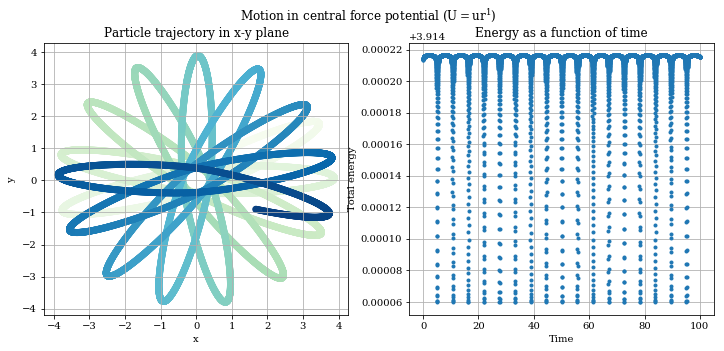

In [5]:
CFP_verlet(1, [1, 1], [2, 1])

The ratio 2<K>/<U> is 0.9747095169015831


<Figure size 432x288 with 0 Axes>

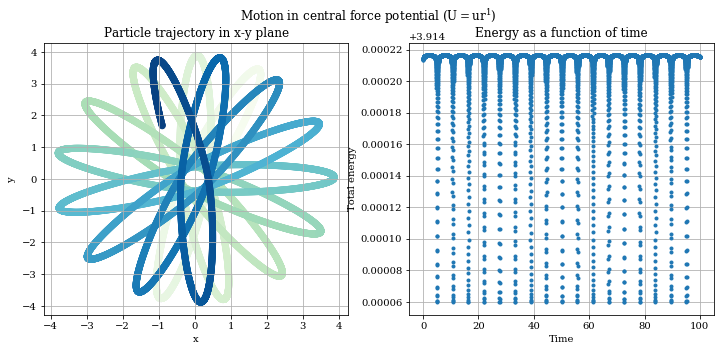

In [6]:
CFP_verlet(1, [1, 1], [1, 2])

The ratio 2<K>/<U> is 0.9998200240302444


<Figure size 432x288 with 0 Axes>

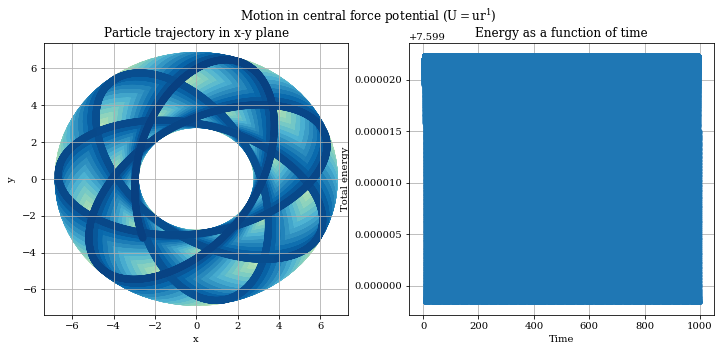

In [7]:
CFP_verlet(1, [5, 1], [1, 2], N=100000)

##### Case 2: $n=2$ with different initial conditions

The ratio 2<K>/<U> is 1.7117720539791492


<Figure size 432x288 with 0 Axes>

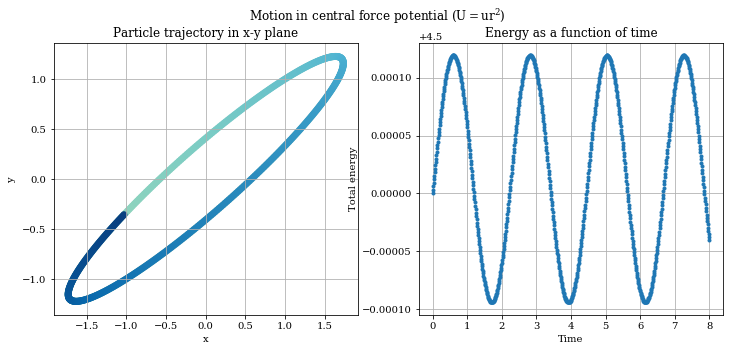

In [8]:
CFP_verlet(2, [1, 1], [2, 1], N=800)

The ratio 2<K>/<U> is 1.7117720539791492


<Figure size 432x288 with 0 Axes>

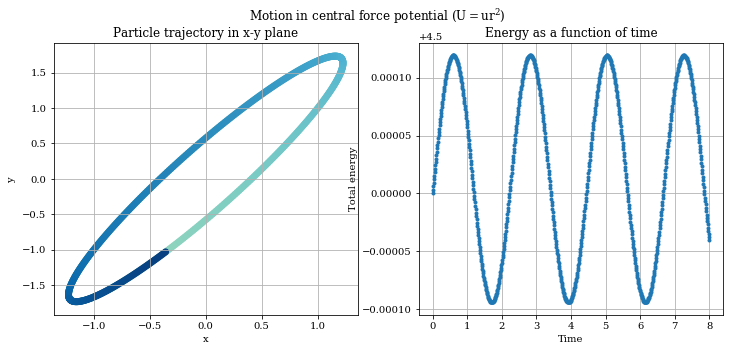

In [9]:
CFP_verlet(2, [1, 1], [1, 2], N=800)

The ratio 2<K>/<U> is 1.9983552664110888


<Figure size 432x288 with 0 Axes>

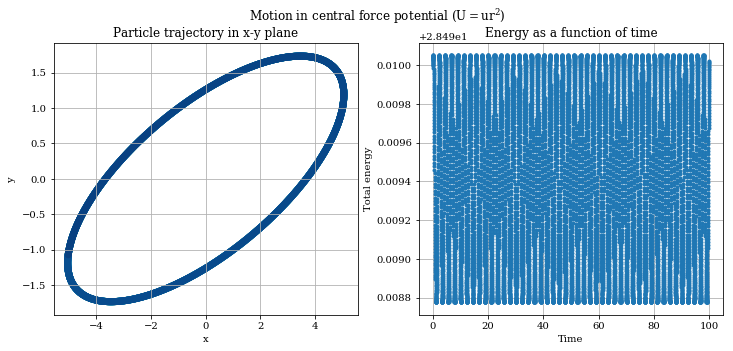

In [10]:
CFP_verlet(2, [5, 1], [1, 2])

The ratio 2<K>/<U> is 1.9992004990180825


<Figure size 432x288 with 0 Axes>

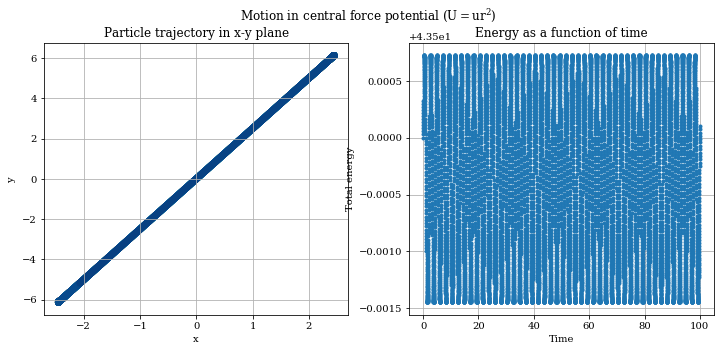

In [11]:
CFP_verlet(2, [2, 5], [2, 5])

##### Case 3: $n=4$ with different initial conditions

The ratio 2<K>/<U> is 3.860485719826349


<Figure size 432x288 with 0 Axes>

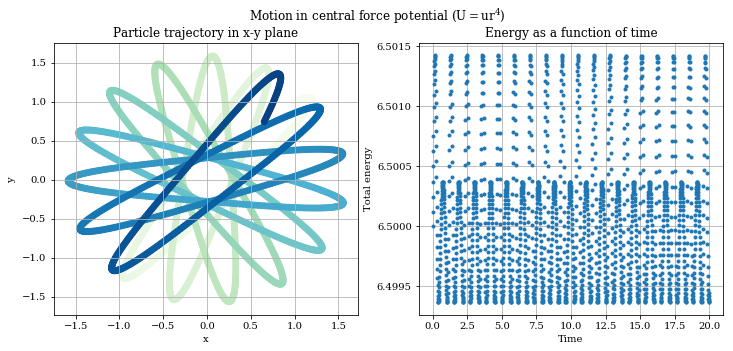

In [12]:
CFP_verlet(4, [1, 1], [2, 1], N=2000)

The ratio 2<K>/<U> is 3.9992462776230955


<Figure size 432x288 with 0 Axes>

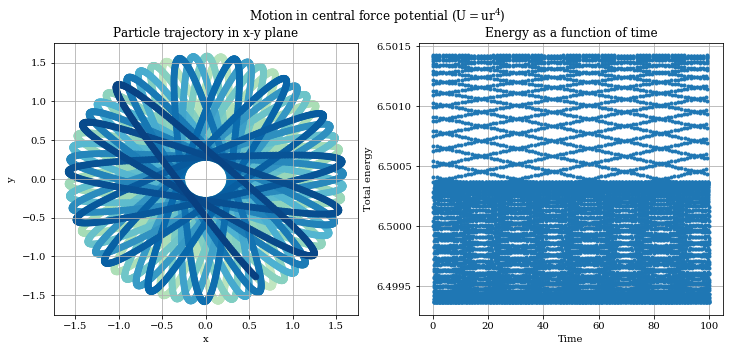

In [13]:
CFP_verlet(4, [1, 1], [1, 2])

The ratio 2<K>/<U> is 3.9870059956969452


<Figure size 432x288 with 0 Axes>

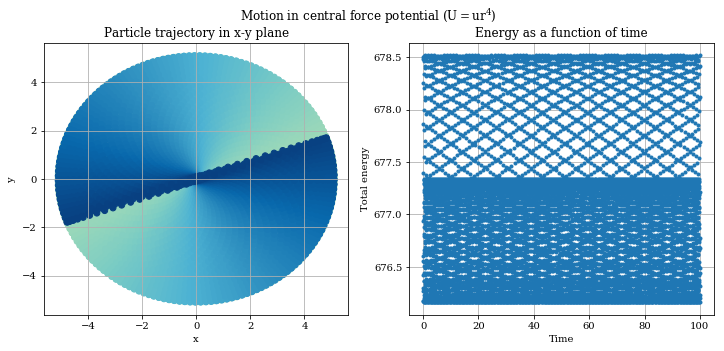

In [14]:
CFP_verlet(4, [1, 5], [1, 2])

The ratio 2<K>/<U> is 3.9913962367882214


<Figure size 432x288 with 0 Axes>

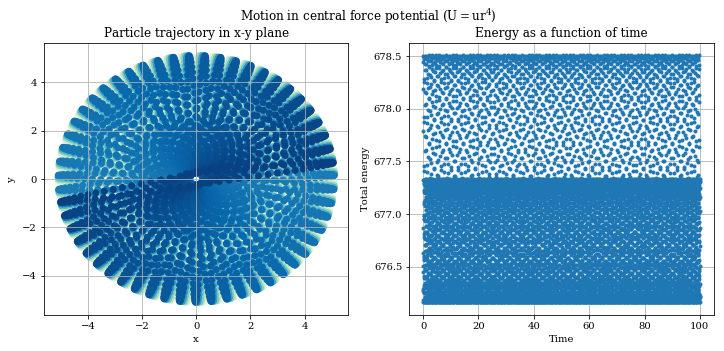

In [15]:
CFP_verlet(4, [5, 1], [1, 2])

#### Part 3 of H1.2: Another case: $U = -un^{-r}$

In this part, instead of re-deriving the equations of the velocity Verlet algorithm, it is more convenient to just replace $n$ with $-n$, $u$ with $-u$ in the equations used in the first model. Below we also vary the initial conditions and the values of $n$ (such as $n=1$, $n=2$, and $n=4$). Upon a bunch of trials with various values of $n$ and various initial conditions, I found that the estimation of the energy and the value of #n# is extremely sensitive to the initial conditions. To find a better set of parameters, I followed the principles as follows:
- Fix the initial position of the particle at any certain point and vary only one component of the momentum. 
- Adjust one component of the momentum based either on
  - the trajectory of the particle in the x-y plane. For example, an excessively large initial velocity might cause the particle to orbit with a decreasing radius, in which case we can decrease the magnitude of the velocity. On the other hand, if the particle leaves the orbit, increasing the magnitude of the velocity might work.
  - how close the ratio $2<K>/<U>$ is to the expected value
- Start with a smaller number of steps (several thousand) to save time. Once the trajectory is closed, try to increase the number of steps with a smaller timestep. Since a small timestep is more numerically stable, it would be easier to find a better set of parameters. (If the timestep is too big, the error would accumulate much faster and "explode" after a short period.)
- The larger the value of $n$ is, the less numerically stable the calculation is, since the error would accumulate faster given a higher order. 
- Start with a position further from the origin, where the singularity occurs. 

From the figures below, we also have several interesting observation:
- For all values of $n$, the trajectory of the particle is a circle (if the trajectory is closed).
- For all values of $n$, the model also follows virial theorem (according to the ratio $2<K>/<U>$.
- For $n=1$, the energy of the particle fluctuates with a certain period, while for $n=2$, the energy fluctuates more randomly and for $n=4$, the energy increases with time. Since the magnitudes of the fluctuations are all very small, we can still tell that the velocity Verlet algorithm is able to conserve the energy of the particle. 
- Interestingly, for the case that $n=2$, with the initial position being $(0, 2)$, it seems that there is an exact magnitude of the x component of the momentum that can generate a ratio that is extremely close to its real value. If the initial position is $(0, 1)$, then a momentum of $(\sqrt(2), 0)$ would work. Similarly, a momentum of $(n \sqrt{2}, 0)$ would work if the initial position is $(n, 0)$. Therefore, we believe that there is an exact mathematical expression behind at least for the case that $n=2$. 

The ratio 2<K>/<U> is -0.999999748736597


<Figure size 432x288 with 0 Axes>

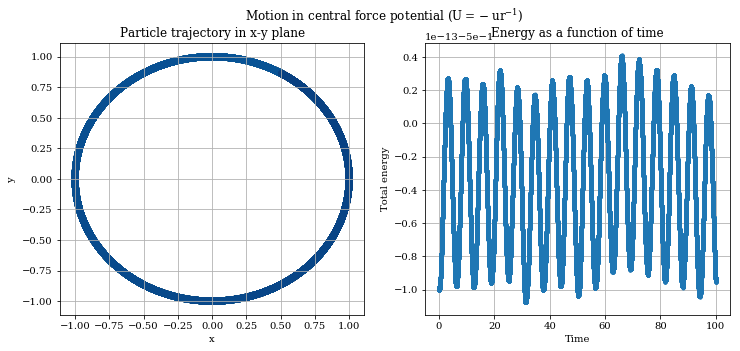

In [16]:
CFP_verlet(1, [0, 1], [-1, 0], model1=False, dt=0.001, N=100000)

The ratio 2<K>/<U> is -2.0000000000000915


<Figure size 432x288 with 0 Axes>

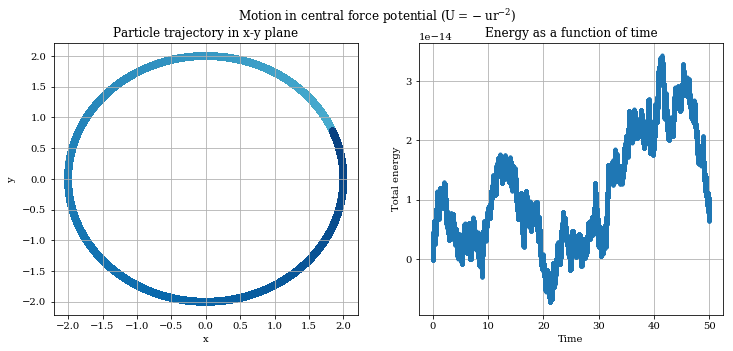

In [17]:
CFP_verlet(2, [0, 2], [-0.5*np.sqrt(2), 0], model1=False, dt=0.0001, N=500000)

The ratio 2<K>/<U> is -4.001949125634749


<Figure size 432x288 with 0 Axes>

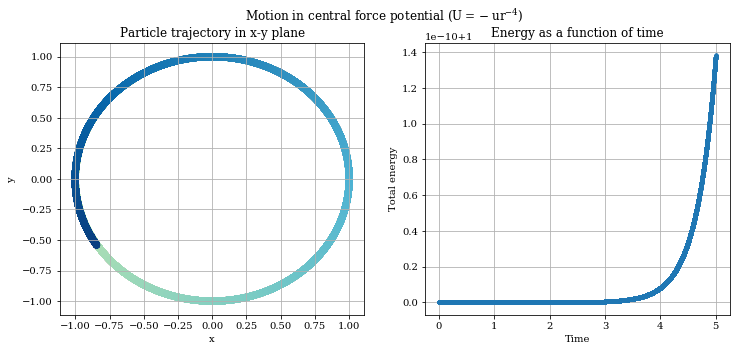

In [18]:
CFP_verlet(4, [1, 0], [0, 2], model1=False, dt=0.0001, N=50000)